<a href="https://colab.research.google.com/github/shane-harris/CSC131-Lab1/blob/master/Network_Intrusion_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import csv
import io
import requests
import os
import collections
import random
import time
import sklearn

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.feature_extraction.text as sk_text

from sklearn import metrics
from sklearn import preprocessing 
from sklearn import svm, datasets
from sklearn.linear_model import Lasso
from sklearn.metrics import roc_curve, auc
from matplotlib.pyplot import figure, show
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

In [ ]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [ ]:
# Simple function to evaluate the coefficients of a regression

%matplotlib inline    
from IPython.display import display   

def report_coef(names,coef,intercept):
    r = pd.DataFrame( { 'coef': coef, 'positive': coef>=0  }, index = names )
    r = r.sort_values(by=['coef'])
    display(r)
    print("Intercept: {}".format(intercept))
    r['coef'].plot(kind='barh', color=r['positive'].map({True: 'b', False: 'r'}))

In [ ]:
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
r

In [ ]:
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

In [ ]:
#Read in csv file
# File obtained from D.O.D public record
networkTraffic = pd.read_csv("network_intrusion_data.csv")

In [ ]:
# Labling each column
# This will be useful later when processing data
networkTraffic.columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'outcome']

In [ ]:
# Displaying the shape of the data for further processing
networkTraffic.shape

(494020, 42)

In [ ]:
# Writing data into another dataframe that contains the labled columns
networkTraffic = networkTraffic[~networkTraffic['service'].str.contains('red_i')]

In [ ]:
# Saving data into another dataframe into google drive
# This will save time diring multiple data processing attempts
networkTraffic.to_csv(r'network_intrusion_data_named.csv')

In [ ]:
# Removing duplicate rows. Apparently there are ALOT of duplicates
# Removal of duplicate rows will help to eliminate the introduction of a bias into the model
networkTraffic_reduced = networkTraffic.drop_duplicates()
networkTraffic_reduced.shape

(145584, 42)

In [ ]:
# Seperating out Normal Traffic and Attack Traffic
# This is done because you want an equal ammount of Attack traffic vs Normal traffic
# This step further removed the possability of intoduction of a bias in the model
networkNormal = networkTraffic_reduced[networkTraffic_reduced['outcome']=='normal.']
networkAttack = networkTraffic_reduced[networkTraffic_reduced['outcome']!='normal.']

In [ ]:
# There are more records of normal traffic than attack traffic
networkNormal.shape

(87830, 42)

In [ ]:
networkAttack.shape

(57754, 42)

In [ ]:
# Shuffling normal network traffic data
# Doing this before removing some of the normal
# traffic will reduce risk of eliminating all
# the traffic from a single source
network_normal_shuffle = networkNormal.sample(frac=1).reset_index(drop=True)

In [ ]:
network_normal_shuffle.shape

(87830, 42)

In [ ]:
# Reducing number of Normal network traffic records
# to match number of Attack network Traffic records
network_normal_shuffle_reduced = network_normal_shuffle.head(networkAttack.shape[0])

In [ ]:
network_normal_shuffle_reduced.shape

(57754, 42)

In [ ]:
# Recombining reduced Normal network traffic to 
# Attack traffic then shuffling dataframe
networkTraffic_reduced_shuffle = pd.concat([network_normal_shuffle_reduced,networkAttack], axis=0)
networkTraffic_reduced_shuffle = networkTraffic_reduced_shuffle.sample(frac=1).reset_index(drop=True)
networkTraffic_reduced_shuffle.shape

(115508, 42)

In [ ]:
#Segmenting out the protocol type for later encoding
protocol_type = networkTraffic_reduced_shuffle['protocol_type']
protocol_type.shape

(115508,)

In [ ]:
#protocol_type

In [ ]:
#Segmenting out services for later encoding
service = networkTraffic_reduced_shuffle['service']
service.shape

(115508,)

In [ ]:
#Segmenting out flags for later encoding
flags = networkTraffic_reduced_shuffle['flag']
flags.shape

(115508,)

In [ ]:
outcome = networkTraffic_reduced_shuffle['outcome']

In [ ]:
outcome.shape

(115508,)

In [ ]:
# 4 verctorizers because of 4 One Hot encoded columns
vectorizer1 = sk_text.CountVectorizer(min_df=0)
vectorizer2 = sk_text.CountVectorizer(min_df=0)
vectorizer3 = sk_text.CountVectorizer(min_df=0)
# May be needed for later parts of the assignment
vectorizer4 = sk_text.CountVectorizer(min_df=0)
# vectorizer1
# vectorizer2
# vectorizer3

In [ ]:
protocol_type_matrix = vectorizer1.fit_transform(protocol_type)

In [ ]:
service_matrix = vectorizer2.fit_transform(service)

In [ ]:
flags_matrix = vectorizer3.fit_transform(flags)

In [ ]:
outcome_matrix = vectorizer4.fit_transform(outcome)

In [ ]:
#print(outcome_matrix.toarray())
outcome_matrix

<115508x23 sparse matrix of type '<class 'numpy.int64'>'
	with 115508 stored elements in Compressed Sparse Row format>

In [ ]:
print(protocol_type_matrix.toarray())

[[0 1 0]
 [0 1 0]
 [0 1 0]
 ...
 [0 1 0]
 [0 1 0]
 [0 1 0]]


In [ ]:
print(flags_matrix.toarray())

[[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
print(service_matrix.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# print(outcome_matrix.toarray())

In [ ]:
protocol_type_matrix.shape

(115508, 3)

In [ ]:
service_matrix.shape

(115508, 65)

In [ ]:
flags_matrix.shape

(115508, 11)

In [ ]:
outcome_matrix.shape

(115508, 23)

In [ ]:
print(vectorizer1.get_feature_names())

['icmp', 'tcp', 'udp']


In [ ]:
print(vectorizer2.get_feature_names())

['auth', 'bgp', 'courier', 'csnet_ns', 'ctf', 'daytime', 'discard', 'domain', 'domain_u', 'echo', 'eco_i', 'ecr_i', 'efs', 'exec', 'finger', 'ftp', 'ftp_data', 'gopher', 'hostnames', 'http', 'http_443', 'imap4', 'irc', 'iso_tsap', 'klogin', 'kshell', 'ldap', 'link', 'login', 'mtp', 'name', 'netbios_dgm', 'netbios_ns', 'netbios_ssn', 'netstat', 'nnsp', 'nntp', 'ntp_u', 'other', 'pm_dump', 'pop_2', 'pop_3', 'printer', 'private', 'remote_job', 'rje', 'shell', 'smtp', 'sql_net', 'ssh', 'sunrpc', 'supdup', 'systat', 'telnet', 'tftp_u', 'tim_i', 'time', 'urh_i', 'urp_i', 'uucp', 'uucp_path', 'vmnet', 'whois', 'x11', 'z39_50']


In [ ]:
print(vectorizer3.get_feature_names())

['oth', 'rej', 'rsto', 'rstos0', 'rstr', 's0', 's1', 's2', 's3', 'sf', 'sh']


In [ ]:
print(vectorizer4.get_feature_names())

['back', 'buffer_overflow', 'ftp_write', 'guess_passwd', 'imap', 'ipsweep', 'land', 'loadmodule', 'multihop', 'neptune', 'nmap', 'normal', 'perl', 'phf', 'pod', 'portsweep', 'rootkit', 'satan', 'smurf', 'spy', 'teardrop', 'warezclient', 'warezmaster']


In [ ]:
networkTraffic_Normalized = networkTraffic_reduced_shuffle

In [ ]:
#networkTraffic_reduced['protocol_type']

In [ ]:
del networkTraffic_Normalized['protocol_type']
del networkTraffic_Normalized['service']
del networkTraffic_Normalized['flag']
del networkTraffic_Normalized['outcome']

In [ ]:
# Transforming the column's protocol_type, service, and flag from
# a matrix that had been One Hot Encoded back to a dataframe
# these will then be appended to the network traffic data

protocol_type_vectorized = pd.DataFrame(protocol_type_matrix.todense(), columns=vectorizer1.get_feature_names())
service_vectorized = pd.DataFrame(service_matrix.todense(), columns=vectorizer2.get_feature_names())
flags_vectorized = pd.DataFrame(flags_matrix.todense(), columns=vectorizer3.get_feature_names())
outcome_vectorized = pd.DataFrame(outcome_matrix.todense(), columns=vectorizer4.get_feature_names())

In [ ]:
# outcome_encoded = pd.concat([outcome_encoded], axis=1)
# outcome_encoded.reset_index(drop=True, level = 0)
# outcome_encoded.shape

In [ ]:
protocol_type_vectorized.shape

(115508, 3)

In [ ]:
service_vectorized.shape

(115508, 65)

In [ ]:
flags_vectorized.shape

(115508, 11)

In [ ]:
outcome_vectorized.shape

(115508, 23)

In [ ]:
#networkTraffic_Normalized_vectorized = pd.concat([protocol_type_vectorized, service_vectorized, flags_vectorized, outcome_encoded], axis=1)
#networkTraffic_Normalized_vectorized = pd.concat([protocol_type_vectorized, service_vectorized, flags_vectorized, outcome_encoded], axis=1)
networkTraffic_Normalized_vectorized = pd.concat([protocol_type_vectorized, service_vectorized, flags_vectorized], axis=1)
networkTraffic_Normalized_vectorized.reset_index(drop=True)
networkTraffic_Normalized_vectorized.shape

(115508, 79)

In [ ]:
outcome_vectorized.head()

,back,buffer_overflow,ftp_write,guess_passwd,imap,ipsweep,land,loadmodule,multihop,neptune,nmap,normal,perl,phf,pod,portsweep,rootkit,satan,smurf,spy,teardrop,warezclient,warezmaster
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# outcome_vectorized.to_csv(r'outcome_vectorized.csv')

In [ ]:
# Extracted just the column labled normal normal= "1" all attacks="0"
outcome_normal_vectorized = outcome_vectorized['normal']
outcome_attack_vectorized = outcome_vectorized['normal'].replace({1:0,0:1})
outcome_attack_vectorized.name = 'attack'

In [ ]:
networkTraffic_Normalized_vectorized.head()

,icmp,tcp,udp,auth,bgp,courier,csnet_ns,ctf,daytime,discard,domain,domain_u,echo,eco_i,ecr_i,efs,exec,finger,ftp,ftp_data,gopher,hostnames,http,http_443,imap4,irc,iso_tsap,klogin,kshell,ldap,link,login,mtp,name,netbios_dgm,netbios_ns,netbios_ssn,netstat,nnsp,nntp,ntp_u,other,pm_dump,pop_2,pop_3,printer,private,remote_job,rje,shell,smtp,sql_net,ssh,sunrpc,supdup,systat,telnet,tftp_u,tim_i,time,urh_i,urp_i,uucp,uucp_path,vmnet,whois,x11,z39_50,oth,rej,rsto,rstos0,rstr,s0,s1,s2,s3,sf,sh
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
# Concatinating Normal and attack Columns to dataframe
networkTraffic_Normalized_vectorized1 = pd.concat([networkTraffic_Normalized_vectorized, outcome_normal_vectorized, outcome_attack_vectorized], axis=1)

# Concatinating All Attack types to dataframe to classify individual attacks
networkTraffic_Normalized_vectorized2 = pd.concat([networkTraffic_Normalized_vectorized, outcome_vectorized], axis=1)


In [ ]:
#networkTraffic_Normalized_vectorized.append(outcome_encoded).shape
networkTraffic_Normalized_vectorized1.shape

(115508, 81)

In [ ]:
networkTraffic_Normalized_vectorized1.head()

,icmp,tcp,udp,auth,bgp,courier,csnet_ns,ctf,daytime,discard,domain,domain_u,echo,eco_i,ecr_i,efs,exec,finger,ftp,ftp_data,gopher,hostnames,http,http_443,imap4,irc,iso_tsap,klogin,kshell,ldap,link,login,mtp,name,netbios_dgm,netbios_ns,netbios_ssn,netstat,nnsp,nntp,...,other,pm_dump,pop_2,pop_3,printer,private,remote_job,rje,shell,smtp,sql_net,ssh,sunrpc,supdup,systat,telnet,tftp_u,tim_i,time,urh_i,urp_i,uucp,uucp_path,vmnet,whois,x11,z39_50,oth,rej,rsto,rstos0,rstr,s0,s1,s2,s3,sf,sh,normal,attack
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


In [ ]:
# networkTraffic_Normalized.to_csv(r'network_Traffic_removed_columns.csv')

In [ ]:
# networkTraffic_Normalized_vectorized.to_csv(r'network_Traffic_removed_columns_vectorized.csv')

In [ ]:
#* Doing this above instead of below allows the final matrix to have *#
#* Column names for the values that are descrete *#
# Final Normalization then shuffle of all values before training
network_traffic_values = networkTraffic_Normalized.values
min_max_scaler = preprocessing.MinMaxScaler()
network_traffic_scaled = min_max_scaler.fit_transform(network_traffic_values)
networkTraffic_Normalized_scaled = pd.DataFrame(network_traffic_scaled)

In [ ]:
# All the data that is not One Hot Encoded is now appended to the dataframe
# 42 -1 - 1- 1 - 1 + 3 + 65 + 11 + 1 = 118 // Verifying the correct
# number of columns after appending One Hot Encoded columns to dataset
networkTraffic_Normalized_vectorized_encoded_scaled = pd.concat([networkTraffic_Normalized_scaled, networkTraffic_Normalized_vectorized1], axis=1)

# All individual attacks
networkTraffic_Normalized_vectorized_encoded_scaled1 = pd.concat([networkTraffic_Normalized_scaled, networkTraffic_Normalized_vectorized2], axis=1)

In [ ]:
networkTraffic_Normalized_vectorized_encoded_scaled.to_csv(r'networkTraffic_Normalized_vectorized_encoded.csv')
networkTraffic_Normalized_vectorized_encoded_scaled1.to_csv(r'networkTraffic_Normalized_vectorized_encoded_attacks.csv')

In [ ]:
networkTraffic_Normalized_vectorized_encoded_scaled['attack'].head()

0    0
1    1
2    0
3    0
4    0
Name: attack, dtype: int64

In [ ]:
networkTraffic_Normalized_vectorized_encoded_scaled.shape

(115508, 119)

In [ ]:
# adding column names to all the columns again

networkTraffic_Normalized_vectorized_encoded_scaled_column_names = networkTraffic_Normalized_vectorized_encoded_scaled.rename(columns={
    0: 'duration',
    1: 'src_bytes',
    2: 'dst_bytes',
    3: 'land',
    4: 'wrong_fragment',
    5: 'urgent',
    6: 'hot',
    7: 'num_failed_logins',
    8: 'logged_in',
    9: 'num_compromised',
    10: 'root_shell',
    11: 'su_attempted',
    12: 'num_root',
    13: 'num_file_creations',
    14: 'num_shells',
    15: 'num_access_files',
    16: 'num_outbound_cmds',
    17: 'is_host_login',
    18: 'is_guest_login',
    19: 'count',
    20: 'srv_count',
    21: 'serror_rate',
    22: 'srv_serror_rate',
    23: 'rerror_rate',
    24: 'srv_rerror_rate',
    25: 'same_srv_rate',
    26: 'diff_srv_rate',
    27: 'srv_diff_host_rate',
    28: 'dst_host_count',
    29: 'dst_host_srv_count',
    30: 'dst_host_same_srv_rate',
    31: 'dst_host_diff_srv_rate',
    32: 'dst_host_same_src_port_rate',
    33: 'dst_host_srv_diff_host_rate',
    34: 'dst_host_serror_rate',
    35: 'dst_host_srv_serror_rate',
    36: 'dst_host_rerror_rate',
    37: 'dst_host_srv_rerror_rate'
    })
# adding column names to all the columns again

networkTraffic_Normalized_vectorized_encoded_scaled_column_names1 = networkTraffic_Normalized_vectorized_encoded_scaled1.rename(columns={0: 'duration',1: 'src_bytes',2: 'dst_bytes',3: 'land',4: 'wrong_fragment',5: 'urgent',6: 'hot',7: 'num_failed_logins',8: 'logged_in',9: 'num_compromised',10: 'root_shell',11: 'su_attempted',12: 'num_root',13: 'num_file_creations',14: 'num_shells',15: 'num_access_files',16: 'num_outbound_cmds',17: 'is_host_login',18: 'is_guest_login',19: 'count',20: 'srv_count',21: 'serror_rate',22: 'srv_serror_rate',23: 'rerror_rate',24: 'srv_rerror_rate',25: 'same_srv_rate',26: 'diff_srv_rate',27: 'srv_diff_host_rate',28: 'dst_host_count',29: 'dst_host_srv_count',30: 'dst_host_same_srv_rate',31: 'dst_host_diff_srv_rate',32: 'dst_host_same_src_port_rate',33: 'dst_host_srv_diff_host_rate',34: 'dst_host_serror_rate',35: 'dst_host_srv_serror_rate',36: 'dst_host_rerror_rate',37: 'dst_host_srv_rerror_rate'})

In [ ]:
networkTraffic_Normalized_vectorized_encoded_scaled_column_names.columns

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       ...
       'rstos0', 'rstr', 's0', 's1', 's2', 's3', 'sf', 'sh', 'normal',
       'attack'],
      dtype='object', length=119)

In [ ]:
networkTraffic_Normalized_vectorized_encoded_scaled_column_names1.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,icmp,tcp,...,uucp,uucp_path,vmnet,whois,x11,z39_50,oth,rej,rsto,rstos0,rstr,s0,s1,s2,s3,sf,sh,back,buffer_overflow,ftp_write,guess_passwd,imap,ipsweep,land,loadmodule,multihop,neptune,nmap,normal,perl,phf,pod,portsweep,rootkit,satan,smurf,spy,teardrop,warezclient,warezmaster
0,0.0,3.158461e-07,0.000119,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.013699,0.015656,0.0,0.0,0.0,0.0,1.00,0.00,0.25,0.181102,1.000000,1.00,0.00,0.02,0.06,0.0,0.0,0.00,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.555773,0.037182,1.0,1.0,0.0,0.0,0.07,0.05,0.00,1.000000,0.070866,0.07,0.05,0.00,0.00,1.0,1.0,0.00,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.001957,0.003914,0.0,0.0,1.0,1.0,1.00,0.00,1.00,0.976378,0.803150,0.82,0.02,0.00,0.00,0.0,0.0,0.82,1.0,0,1,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0.0,3.374794e-07,0.000523,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.007828,0.007828,0.0,0.0,0.0,0.0,1.00,0.00,0.00,1.000000,0.925197,0.93,0.02,0.00,0.00,0.0,0.0,0.00,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0.0,3.821882e-07,0.000321,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.001957,0.001957,0.0,0.0,0.0,0.0,1.00,0.00,0.00,1.000000,0.964567,0.96,0.01,0.00,0.00,0.0,0.0,0.00,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Spliiting with column names
x_network1 = networkTraffic_Normalized_vectorized_encoded_scaled_column_names.loc[:, networkTraffic_Normalized_vectorized_encoded_scaled_column_names.columns != 'normal']
y_network1 = networkTraffic_Normalized_vectorized_encoded_scaled_column_names['normal']

del x_network1['attack']

# Adding additional column to y so one is an attack column and another is a normal column
#mapping = {y_network1[0]:'attack'}
y_network2 = pd.concat([y_network1, y_network1.replace({1:0,0:1}).rename(columns={0:'Attack'})], axis=1)
y_network2.head()

,normal,0
0,1,0
1,0,1
2,1,0
3,1,0
4,1,0


In [ ]:
networkTraffic_Normalized_vectorized_encoded_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,icmp,tcp,...,other,pm_dump,pop_2,pop_3,printer,private,remote_job,rje,shell,smtp,sql_net,ssh,sunrpc,supdup,systat,telnet,tftp_u,tim_i,time,urh_i,urp_i,uucp,uucp_path,vmnet,whois,x11,z39_50,oth,rej,rsto,rstos0,rstr,s0,s1,s2,s3,sf,sh,normal,attack
0,0.0,3.158461e-07,0.000119,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.013699,0.015656,0.0,0.0,0.0,0.0,1.00,0.00,0.25,0.181102,1.000000,1.00,0.00,0.02,0.06,0.0,0.0,0.00,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.555773,0.037182,1.0,1.0,0.0,0.0,0.07,0.05,0.00,1.000000,0.070866,0.07,0.05,0.00,0.00,1.0,1.0,0.00,0.0,0,1,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.001957,0.003914,0.0,0.0,1.0,1.0,1.00,0.00,1.00,0.976378,0.803150,0.82,0.02,0.00,0.00,0.0,0.0,0.82,1.0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
3,0.0,3.374794e-07,0.000523,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.007828,0.007828,0.0,0.0,0.0,0.0,1.00,0.00,0.00,1.000000,0.925197,0.93,0.02,0.00,0.00,0.0,0.0,0.00,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,0.0,3.821882e-07,0.000321,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.001957,0.001957,0.0,0.0,0.0,0.0,1.00,0.00,0.00,1.000000,0.964567,0.96,0.01,0.00,0.00,0.0,0.0,0.00,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


In [ ]:
# Final Value Shiffle before training
networkTraffic_Normalized_vectorized_encoded_scaled = networkTraffic_Normalized_vectorized_encoded_scaled.sample(frac=1).reset_index(drop=True)

# Shuffling of dataframe containgning individual attacks
networkTraffic_Normalized_vectorized_encoded_scaled1 = networkTraffic_Normalized_vectorized_encoded_scaled1.sample(frac=1).reset_index(drop=True)

In [ ]:
# Copy all columns except for Ground Truth column
# outcome column name changed to normal due to removing from 
# one hot encoded outcome column
temp_df = networkTraffic_Normalized_vectorized_encoded_scaled.loc[:, networkTraffic_Normalized_vectorized_encoded_scaled.columns != 'normal']
x_network = temp_df.loc[:, temp_df.columns != 'attack']
x_network.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,icmp,tcp,...,nntp,ntp_u,other,pm_dump,pop_2,pop_3,printer,private,remote_job,rje,shell,smtp,sql_net,ssh,sunrpc,supdup,systat,telnet,tftp_u,tim_i,time,urh_i,urp_i,uucp,uucp_path,vmnet,whois,x11,z39_50,oth,rej,rsto,rstos0,rstr,s0,s1,s2,s3,sf,sh
0,0.0,1.442220e-09,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.281800,0.262231,0.0,0.0,0.0,0.0,0.93,0.01,0.0,1.0,0.791339,0.79,0.03,1.0,0.0,0.0,0.0,0.00,0.00,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0.0,3.201728e-07,0.006226,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007828,0.007828,0.0,0.0,0.0,0.0,1.00,0.00,0.0,1.0,1.000000,1.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0.0,7.865866e-05,0.001613,0.0,0.0,0.0,0.066667,0.0,1.0,0.003559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003914,0.003914,0.0,0.0,0.0,0.0,1.00,0.00,0.0,1.0,1.000000,1.00,0.00,0.0,0.0,0.0,0.0,0.06,0.06,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.318982,0.045010,1.0,1.0,0.0,0.0,0.14,0.04,0.0,1.0,0.086614,0.09,0.05,0.0,0.0,1.0,1.0,0.00,0.00,0,1,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0.0,4.643947e-07,0.000199,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033268,0.033268,0.0,0.0,0.0,0.0,1.00,0.00,0.0,1.0,1.000000,1.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
# iterating the columns 
for col in networkTraffic_Normalized_vectorized_encoded_scaled1.columns: 
    print("'{col}',".format(col=col), end='')

'0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37','icmp','tcp','udp','auth','bgp','courier','csnet_ns','ctf','daytime','discard','domain','domain_u','echo','eco_i','ecr_i','efs','exec','finger','ftp','ftp_data','gopher','hostnames','http','http_443','imap4','irc','iso_tsap','klogin','kshell','ldap','link','login','mtp','name','netbios_dgm','netbios_ns','netbios_ssn','netstat','nnsp','nntp','ntp_u','other','pm_dump','pop_2','pop_3','printer','private','remote_job','rje','shell','smtp','sql_net','ssh','sunrpc','supdup','systat','telnet','tftp_u','tim_i','time','urh_i','urp_i','uucp','uucp_path','vmnet','whois','x11','z39_50','oth','rej','rsto','rstos0','rstr','s0','s1','s2','s3','sf','sh','back','buffer_overflow','ftp_write','guess_passwd','imap','ipsweep','land','loadmodule','multihop','neptune','nmap','normal','perl','phf','pod','portsweep','rootkit','satan'

In [ ]:
# iterating the columns 
for col in x_network.columns: 
    print("'{col}',".format(col=col), end='')

'0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37','icmp','tcp','udp','auth','bgp','courier','csnet_ns','ctf','daytime','discard','domain','domain_u','echo','eco_i','ecr_i','efs','exec','finger','ftp','ftp_data','gopher','hostnames','http','http_443','imap4','irc','iso_tsap','klogin','kshell','ldap','link','login','mtp','name','netbios_dgm','netbios_ns','netbios_ssn','netstat','nnsp','nntp','ntp_u','other','pm_dump','pop_2','pop_3','printer','private','remote_job','rje','shell','smtp','sql_net','ssh','sunrpc','supdup','systat','telnet','tftp_u','tim_i','time','urh_i','urp_i','uucp','uucp_path','vmnet','whois','x11','z39_50','oth','rej','rsto','rstos0','rstr','s0','s1','s2','s3','sf','sh',

In [ ]:
#x_network1 = networkTraffic_Normalized_vectorized_encoded_scaled1.loc[:, networkTraffic_Normalized_vectorized_encoded_scaled1.columns != 'back', 'buffer_overflow', 'ftp_write', 'guess_passwd', 'imap', 'ipsweep', 'land', 'loadmodule', 'multihop', 'neptune', 'nmap', 'normal', 'perl', 'phf', 'pod', 'portsweep', 'rootkit', 'satan', 'smurf', 'spy', 'teardrop', 'warezclient', 'warezmaster']
x_network3 = networkTraffic_Normalized_vectorized_encoded_scaled1[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,'icmp','tcp','udp','auth','bgp','courier','csnet_ns','ctf','daytime','discard','domain','domain_u','echo','eco_i','ecr_i','efs','exec','finger','ftp','ftp_data','gopher','hostnames','http','http_443','imap4','irc','iso_tsap','klogin','kshell','ldap','link','login','mtp','name','netbios_dgm','netbios_ns','netbios_ssn','netstat','nnsp','nntp','ntp_u','other','pm_dump','pop_2','pop_3','printer','private','remote_job','rje','shell','smtp','sql_net','ssh','sunrpc','supdup','systat','telnet','tim_i','time','urh_i','urp_i','uucp','uucp_path','vmnet','whois','x11','z39_50','oth','rej','rsto','rstos0','rstr','s0','s1','s2','s3','sf','sh']]
x_network3.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,icmp,tcp,...,nnsp,nntp,ntp_u,other,pm_dump,pop_2,pop_3,printer,private,remote_job,rje,shell,smtp,sql_net,ssh,sunrpc,supdup,systat,telnet,tim_i,time,urh_i,urp_i,uucp,uucp_path,vmnet,whois,x11,z39_50,oth,rej,rsto,rstos0,rstr,s0,s1,s2,s3,sf,sh
0,0.0,3.172883e-07,0.000526,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043053,0.043053,0.0,0.0,0.0,0.0,1.00,0.00,0.0,0.988189,1.000000,1.00,0.00,0.0,0.01,0.0,0.0,0.0,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.356164,0.027397,0.0,0.0,1.0,1.0,0.08,0.07,0.0,1.000000,0.051181,0.05,0.07,0.0,0.00,0.0,0.0,1.0,1.0,0,1,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.542074,0.045010,1.0,1.0,0.0,0.0,0.08,0.05,0.0,1.000000,0.086614,0.09,0.06,0.0,0.00,1.0,1.0,0.0,0.0,0,1,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0.0,6.201545e-08,0.000011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.003914,0.0,0.0,0.0,0.0,1.00,0.00,1.0,1.000000,0.984252,0.98,0.01,0.0,0.00,0.0,0.0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.0,6.201545e-08,0.000008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.191781,0.191781,0.0,0.0,0.0,0.0,1.00,0.00,0.0,1.000000,0.889764,0.89,0.01,0.0,0.00,0.0,0.0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
# iterating the columns 
for col in x_network3.columns: 
    print("'{col}',".format(col=col), end='')

'0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37','icmp','tcp','udp','auth','bgp','courier','csnet_ns','ctf','daytime','discard','domain','domain_u','echo','eco_i','ecr_i','efs','exec','finger','ftp','ftp_data','gopher','hostnames','http','http_443','imap4','irc','iso_tsap','klogin','kshell','ldap','link','login','mtp','name','netbios_dgm','netbios_ns','netbios_ssn','netstat','nnsp','nntp','ntp_u','other','pm_dump','pop_2','pop_3','printer','private','remote_job','rje','shell','smtp','sql_net','ssh','sunrpc','supdup','systat','telnet','tim_i','time','urh_i','urp_i','uucp','uucp_path','vmnet','whois','x11','z39_50','oth','rej','rsto','rstos0','rstr','s0','s1','s2','s3','sf','sh',

In [ ]:
# Copy just Ground Truth Column
y_network = networkTraffic_Normalized_vectorized_encoded_scaled['normal']
y_network.shape

(115508,)

In [ ]:
# Copy just Ground Truth Column + individual attacks
y_network3 = networkTraffic_Normalized_vectorized_encoded_scaled1[['back', 'buffer_overflow', 'ftp_write', 'guess_passwd', 'imap', 'ipsweep', 'land', 'loadmodule', 'multihop', 'neptune', 'nmap', 'normal', 'perl', 'phf', 'pod', 'portsweep', 'rootkit', 'satan', 'smurf', 'spy', 'teardrop', 'warezclient', 'warezmaster']]
y_network3.shape

(115508, 23)

In [ ]:
y_network3.head()

,back,buffer_overflow,ftp_write,guess_passwd,imap,ipsweep,land,loadmodule,multihop,neptune,nmap,normal,perl,phf,pod,portsweep,rootkit,satan,smurf,spy,teardrop,warezclient,warezmaster
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Creating additional column for the Y to have 2outputs
attack = y_network.replace({1:0,0:1})
attack1 = attack.rename(columns={0: 'attack'})
attack1.head()

0    1
1    0
2    1
3    1
4    0
dtype: int64

In [ ]:
y_network.shape

(115508,)

In [ ]:
#Split data into Train/Test
x_network_train, x_network_test, y_network_train, y_network_test = train_test_split(x_network, y_network, test_size=0.20, random_state=42)
# Split data for Dense Neural Network
x_network_train_dense, x_network_test_dense, y_network_train_dense, y_network_test_dense = train_test_split(x_network1, y_network2, test_size=0.20, random_state=42)
# Split data for Dense Neural Network individual attacks
x_network_train_dense_attacks, x_network_test_dense_attacks, y_network_train_dense_attacks, y_network_test_dense_attacks = train_test_split(x_network3, y_network3, test_size=0.20, random_state=42)

In [ ]:
y_network_train_dense.head()

,normal,0
75364,1,0
47884,0,1
85816,1,0
80034,1,0
67472,0,1


In [ ]:
y_network_test_dense.head()

,normal,0
71928,1,0
78900,1,0
36810,1,0
90832,1,0
40820,0,1


In [ ]:
y_network_train.head()

75364    1
47884    1
85816    0
80034    0
67472    1
Name: normal, dtype: int64

In [ ]:
y_network_test.head()

71928    0
78900    1
36810    1
90832    0
40820    1
Name: normal, dtype: int64

In [ ]:
x_network.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,icmp,tcp,...,nntp,ntp_u,other,pm_dump,pop_2,pop_3,printer,private,remote_job,rje,shell,smtp,sql_net,ssh,sunrpc,supdup,systat,telnet,tftp_u,tim_i,time,urh_i,urp_i,uucp,uucp_path,vmnet,whois,x11,z39_50,oth,rej,rsto,rstos0,rstr,s0,s1,s2,s3,sf,sh
0,0.0,1.442220e-09,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.281800,0.262231,0.0,0.0,0.0,0.0,0.93,0.01,0.0,1.0,0.791339,0.79,0.03,1.0,0.0,0.0,0.0,0.00,0.00,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0.0,3.201728e-07,0.006226,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007828,0.007828,0.0,0.0,0.0,0.0,1.00,0.00,0.0,1.0,1.000000,1.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0.0,7.865866e-05,0.001613,0.0,0.0,0.0,0.066667,0.0,1.0,0.003559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003914,0.003914,0.0,0.0,0.0,0.0,1.00,0.00,0.0,1.0,1.000000,1.00,0.00,0.0,0.0,0.0,0.0,0.06,0.06,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.318982,0.045010,1.0,1.0,0.0,0.0,0.14,0.04,0.0,1.0,0.086614,0.09,0.05,0.0,0.0,1.0,1.0,0.00,0.00,0,1,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0.0,4.643947e-07,0.000199,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033268,0.033268,0.0,0.0,0.0,0.0,1.00,0.00,0.0,1.0,1.000000,1.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
# Converting all to numpy arrays for model to train from
# Reshaping the data from 2D 4D for CNN model
# Convert dataframe to numpy array then reshape
# via the number of records and the number of features per record


x_train_cnn = x_network_train.to_numpy().reshape((x_network_train.shape[0], 1, x_network.shape[1], 1))
x_test_cnn = x_network_test.to_numpy().reshape((x_network_test.shape[0], 1, x_network.shape[1], 1))
y_train_cnn = tf.keras.utils.to_categorical(y_network_train.to_numpy(), 2)
y_test_cnn = tf.keras.utils.to_categorical(y_network_test.to_numpy(), 2)

# These X's and Y's have a single column 1=Attack 0=normal
x_train_dense1 = x_network_train.to_numpy()
x_test_dense1 = x_network_test.to_numpy()
y_train_dense1 = y_network_train.to_numpy()
y_test_dense1 = y_network_test.to_numpy()

# These X's and Y's have 2 columns 1 for normal activity and 1 for Attacks
x_train_dense2 = x_network_train_dense.to_numpy()
x_test_dense2 = x_network_test_dense.to_numpy()
y_train_dense2 = y_network_train_dense.to_numpy()
y_test_dense2= y_network_test_dense.to_numpy()

# y_train_dense2 = tf.keras.utils.to_categorical(y_network_train_dense.to_numpy(), 2)
# y_test_dense2= tf.keras.utils.to_categorical(y_network_test_dense.to_numpy(), 2)

# These X's and Y's have 2 columns 1 for normal activity and 1 for Attacks
x_train_dense_attacks = x_network_train_dense_attacks.to_numpy()
x_test_dense_attacks = x_network_test_dense_attacks.to_numpy()
y_train_dense_attacks = tf.keras.utils.to_categorical(y_network_train_dense_attacks.to_numpy(), 2)
y_test_dense_attacks = tf.keras.utils.to_categorical(y_network_test_dense_attacks.to_numpy(), 2)

In [ ]:
# iterating the columns 
for col in x_network_test_dense.columns: 
    print("'{col}',".format(col=col))


'duration',
'src_bytes',
'dst_bytes',
'land',
'wrong_fragment',
'urgent',
'hot',
'num_failed_logins',
'logged_in',
'num_compromised',
'root_shell',
'su_attempted',
'num_root',
'num_file_creations',
'num_shells',
'num_access_files',
'num_outbound_cmds',
'is_host_login',
'is_guest_login',
'count',
'srv_count',
'serror_rate',
'srv_serror_rate',
'rerror_rate',
'srv_rerror_rate',
'same_srv_rate',
'diff_srv_rate',
'srv_diff_host_rate',
'dst_host_count',
'dst_host_srv_count',
'dst_host_same_srv_rate',
'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate',
'dst_host_serror_rate',
'dst_host_srv_serror_rate',
'dst_host_rerror_rate',
'dst_host_srv_rerror_rate',
'icmp',
'tcp',
'udp',
'auth',
'bgp',
'courier',
'csnet_ns',
'ctf',
'daytime',
'discard',
'domain',
'domain_u',
'echo',
'eco_i',
'ecr_i',
'efs',
'exec',
'finger',
'ftp',
'ftp_data',
'gopher',
'hostnames',
'http',
'http_443',
'imap4',
'irc',
'iso_tsap',
'klogin',
'kshell',
'ldap',
'link',
'login',
'mtp',
'nam

In [ ]:
print(y_train_dense2)

[[1 0]
 [0 1]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]


In [ ]:
x_train_cnn.shape

(92406, 1, 117, 1)

In [ ]:
x_network_train.shape

(92406, 117)

In [ ]:
batch_size = 128

In [ ]:
if not os.path.exists('best_weights_all_features'):
  os.mkdir('best_weights_all_features')

In [ ]:
# define a CNN 
# This will be the first training without removing any features

start_time = time.time()

cnn = Sequential()

cnn.add(Conv2D(32, kernel_size=(1, 2), strides=(1, 1), padding='same',
                 activation='relu',
                 input_shape=(x_train_cnn.shape[1:])))

# the above code is equivalent to 
# model.add(Conv1D(64, kernel_size=3, strides=1, activation='relu', input_shape=(128, 1)))

cnn.add(MaxPooling2D(pool_size=(1,2)))

cnn.add(Conv2D(64, kernel_size=(1, 2), strides=(1, 1), padding='same',
                  activation='relu'))
cnn.add(MaxPooling2D(pool_size=(1,2)))
    
    
cnn.add(Flatten())
cnn.add(Dense(128, activation="relu"))
#cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation="softmax"))

# define optimizer and objective, compile cnn

cnn.compile(loss="categorical_crossentropy", optimizer="adam")

# Defining check and monitor for early stopping and svaing best model
checkpointer = ModelCheckpoint(filepath="best_weights_all_features/best_weights_all_features.hdf5", verbose=2, save_best_only=True)
monitor = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=2, mode='auto')

cnn.fit(x_train_cnn, y_train_cnn,     
          batch_size=batch_size,
          epochs=10,
          verbose=2,
          callbacks=[monitor,checkpointer],
          validation_data=(x_test_cnn, y_test_cnn))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 92406 samples, validate on 23102 samples
Epoch 1/10

Epoch 00001: val_loss improved from inf to 0.02270, saving model to best_weights_all_features/best_weights_all_features.hdf5
92406/92406 - 7s - loss: 0.0509 - val_loss: 0.0227
Epoch 2/10

Epoch 00002: val_loss improved from 0.02270 to 0.01251, saving model to best_weights_all_features/best_weights_all_features.hdf5
92406/92406 - 5s - loss: 0.0168 - val_loss: 0.0125
Epoch 3/10

Epoch 00003: val_loss improved from 0.01251 to 0.00921, saving model to best_weights_all_features/best_weights_all_features.hdf5
92406/92406 - 5s - loss: 0.0098 - val_loss: 0.0092
Epoch 4/10

Epoch 00004: val_loss improved from 0.00921 to 0.00734, saving model to best_weights_all_features/best_weights_all_features.hdf5
92406/92406 - 5s - loss: 0.0085 - val_loss: 0.0073
Epoch 5/10

Epoch 00005: val_loss improved from 0.00734 to 0.00722, saving model to best_weights_all_feat

In [ ]:
cnn.load_weights('best_weights_all_features/best_weights_all_features.hdf5')

In [ ]:
# evaluate() computes the loss and accuracy
score = cnn.evaluate(x_test_cnn, y_test_cnn, verbose=0)
score

0.006383469073510161

In [ ]:
cnn.metrics_names

['loss']

In [ ]:
# print('Test loss: {}'.format(score[0]))
# print('Test accuracy: {}'.format(score[1]))
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 117, 32)        96        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 58, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 58, 64)         4160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 29, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1856)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               237696    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

In [ ]:
y_true_cnn = np.argmax(y_test_cnn,axis=1)
pred_cnn = cnn.predict(x_test_cnn)
pred_cnn = np.argmax(pred_cnn,axis=1)


score_cnn = metrics.accuracy_score(y_true_cnn, pred_cnn)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true_cnn, pred_cnn, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true_cnn, pred_cnn))

Accuracy: 0.006383469073510161
Averaged F1: 0.9980520847083437
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11372
           1       1.00      1.00      1.00     11730

    accuracy                           1.00     23102
   macro avg       1.00      1.00      1.00     23102
weighted avg       1.00      1.00      1.00     23102



In [ ]:
# Encoding the outcome column from the original dataframe

outcome_final = encode_text_index(networkTraffic_Normalized_vectorized_encoded_scaled,'normal')

[[11338    34]
 [   11 11719]]
Plotting confusion matrix


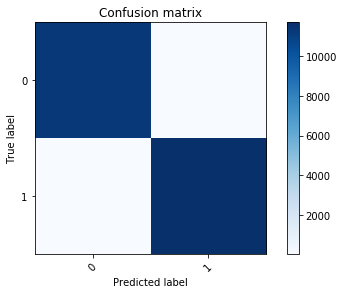

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11372
           1       1.00      1.00      1.00     11730

    accuracy                           1.00     23102
   macro avg       1.00      1.00      1.00     23102
weighted avg       1.00      1.00      1.00     23102



In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true_cnn, pred_cnn)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, outcome_final)
plt.show()

print(classification_report(y_true_cnn, pred_cnn))

In [ ]:
x_network.shape

(115508, 117)

In [ ]:
y_network2.shape

(115508, 2)

In [ ]:
import os
if not os.path.exists('best_weights_dense1'):
  os.mkdir('best_weights_dense1')
if not os.path.exists('best_weights_dense2'):
  os.mkdir('best_weights_dense2') 
if not os.path.exists('best_weights_all_features'):
  os.mkdir('best_weights_all_features')

In [ ]:
x_network1.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,icmp,tcp,...,nntp,ntp_u,other,pm_dump,pop_2,pop_3,printer,private,remote_job,rje,shell,smtp,sql_net,ssh,sunrpc,supdup,systat,telnet,tftp_u,tim_i,time,urh_i,urp_i,uucp,uucp_path,vmnet,whois,x11,z39_50,oth,rej,rsto,rstos0,rstr,s0,s1,s2,s3,sf,sh
0,0.0,3.158461e-07,0.000119,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.013699,0.015656,0.0,0.0,0.0,0.0,1.00,0.00,0.25,0.181102,1.000000,1.00,0.00,0.02,0.06,0.0,0.0,0.00,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.555773,0.037182,1.0,1.0,0.0,0.0,0.07,0.05,0.00,1.000000,0.070866,0.07,0.05,0.00,0.00,1.0,1.0,0.00,0.0,0,1,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.001957,0.003914,0.0,0.0,1.0,1.0,1.00,0.00,1.00,0.976378,0.803150,0.82,0.02,0.00,0.00,0.0,0.0,0.82,1.0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0.0,3.374794e-07,0.000523,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.007828,0.007828,0.0,0.0,0.0,0.0,1.00,0.00,0.00,1.000000,0.925197,0.93,0.02,0.00,0.00,0.0,0.0,0.00,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.0,3.821882e-07,0.000321,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.001957,0.001957,0.0,0.0,0.0,0.0,1.00,0.00,0.00,1.000000,0.964567,0.96,0.01,0.00,0.00,0.0,0.0,0.00,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
# This Model is built for a y with 2 columns 1 for normal 
# one for an attack. 

model = Sequential()
model.add(Dense(64, input_dim=x_network1.shape[1], activation='relu'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(y_network_train_dense.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='sgd')

#Stop early if the epochs start to increase
monitor = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

#Saving the best model
checkpointer = ModelCheckpoint(filepath="best_weights_dense2/best_weights_dense2.hdf5", verbose=2, save_best_only=True)
model.fit(x_train_dense2,y_train_dense2,validation_data=(x_test_dense2,y_test_dense2),callbacks=[monitor,checkpointer],verbose=2,epochs=10)

#load weights from best model
model.load_weights('best_weights_dense2/best_weights_dense2.hdf5')


Train on 92406 samples, validate on 23102 samples
Epoch 1/10

Epoch 00001: val_loss improved from inf to 0.09729, saving model to best_weights_dense2/best_weights_dense2.hdf5
92406/92406 - 10s - loss: 0.1689 - acc: 0.9617 - val_loss: 0.0973 - val_acc: 0.9685
Epoch 2/10

Epoch 00002: val_loss improved from 0.09729 to 0.07501, saving model to best_weights_dense2/best_weights_dense2.hdf5
92406/92406 - 10s - loss: 0.0865 - acc: 0.9745 - val_loss: 0.0750 - val_acc: 0.9797
Epoch 3/10

Epoch 00003: val_loss improved from 0.07501 to 0.06301, saving model to best_weights_dense2/best_weights_dense2.hdf5
92406/92406 - 10s - loss: 0.0714 - acc: 0.9801 - val_loss: 0.0630 - val_acc: 0.9820
Epoch 4/10

Epoch 00004: val_loss improved from 0.06301 to 0.05584, saving model to best_weights_dense2/best_weights_dense2.hdf5
92406/92406 - 10s - loss: 0.0624 - acc: 0.9830 - val_loss: 0.0558 - val_acc: 0.9872
Epoch 5/10

Epoch 00005: val_loss improved from 0.05584 to 0.05031, saving model to best_weights_dense

In [ ]:
#load weights from best model
model.load_weights('best_weights_dense2/best_weights_dense2.hdf5')

In [ ]:
x_test_dense2.shape

(23102, 117)

In [ ]:
# evaluate() computes the loss and accuracy
score_dense2 = model.evaluate(x_test_dense2, y_test_dense2, verbose=0)
score_dense2

[0.03737370881116779, 0.98792315]

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                7552      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
Total params: 11,842
Trainable params: 11,842
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_test_dense2.shape

(23102, 2)

In [ ]:
y_true_dense2 = np.argmax(y_test_dense2,axis=1)
pred_dense2 = model.predict(x_test_dense2)
pred_dense2 = np.argmax(pred_dense2,axis=1)


score_dense2 = metrics.accuracy_score(y_true_dense2, pred_dense2)
print('Accuracy: {}'.format(score))


f1_dense2 = metrics.f1_score(y_true_dense2, pred_dense2, average='weighted')
print('Averaged F1: {}'.format(f1_dense2))

           
print(metrics.classification_report(y_true_dense2, pred_dense2))

Accuracy: 0.006383469073510161
Averaged F1: 0.9879220487954341
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     11691
           1       0.99      0.98      0.99     11411

    accuracy                           0.99     23102
   macro avg       0.99      0.99      0.99     23102
weighted avg       0.99      0.99      0.99     23102



In [ ]:
pred_dense2.shape

(23102,)

[[11611    80]
 [  199 11212]]
Plotting confusion matrix


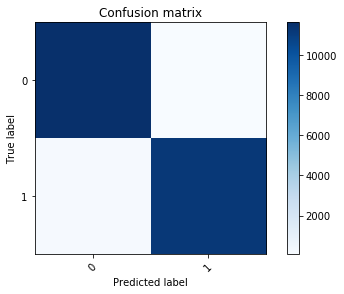

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     11691
           1       0.99      0.98      0.99     11411

    accuracy                           0.99     23102
   macro avg       0.99      0.99      0.99     23102
weighted avg       0.99      0.99      0.99     23102



In [ ]:
#confusion matrix for dense model
dense = confusion_matrix(y_true_dense2, pred_dense2)
print(dense)
plot_co

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(dense, outcome_final)
plt.show()

print(classification_report(y_true_dense2, pred_dense2))

In [ ]:
y_true_dense2 = np.argmax(y_test_dense2,axis=1)
pred_dense2 = model.predict(x_test_dense2)
pred_dense2 = np.argmax(pred_dense2,axis=1)


score_dense2 = metrics.accuracy_score(y_true_dense2, pred_dense2)
print('Accuracy: {}'.format(score))


f1_dense2 = metrics.f1_score(y_true_dense2, pred_dense2, average='weighted')
print('Averaged F1: {}'.format(f1_dense2))

           
print(metrics.classification_report(y_true_dense2, pred_dense2))

Accuracy: 0.006383469073510161
Averaged F1: 0.9879220487954341
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     11691
           1       0.99      0.98      0.99     11411

    accuracy                           0.99     23102
   macro avg       0.99      0.99      0.99     23102
weighted avg       0.99      0.99      0.99     23102



In [ ]:
if not os.path.exists('best_weights_dense_attacks'):
  os.mkdir('best_weights_dense_attacks')

In [ ]:
# This Model is built for a y with 2 columns 1 for normal 
# one for an attack. 

model_attacks = Sequential()

model_attacks.add(Dense(64, input_dim=x_network3.shape[1], activation='relu')) 
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(y_network_train_dense_attacks.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='sgd')

#Stop early if the epochs start to increase
monitor = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

#Saving the best model
checkpointer = ModelCheckpoint(filepath="best_weights_dense_attacks/best_weights_dense_attacks.hdf5", verbose=2, save_best_only=True)

model.fit(x_train_dense_attacks,y_train_dense_attacks,validation_data=(x_test_dense_attacks,y_test_dense_attacks),callbacks=[monitor,checkpointer],verbose=2,epochs=10)

#load weights from best model
model.load_weights('best_weights_dense_attacks/best_weights_dense_attacks.hdf5')

ValueError: ignored